# Description

Scenario :
* 1 receptor
* VS with a set of active ligands and decoys

Requirements :
* Have "ligands" in the mol2 filename of your active molecules, and "decoys" for the others
* Run ScoreFlow
* Fill the User Input section of this notebook
* Click on the "Cell" tab, "Run All"

Output :
* Enrichment rates
* ROC curves
* AUC

# User Input

In [1]:
# Path to data
# The notebook should be ran from the working directory folder.
# You can change the path to the summary folder here.
# Default : path = "."
path = "/data/share/exchange/CB/hivpr_DUD"

In [2]:
# Save folder for tables and graphs
# By default, the save folder will be created inside the output folder
# as "output/ReportFlow/PLANTS_VS_decoys_enrichment"
# You can change the path and names of the save folder here.
# Default : save_folder = "./output/ReportFlow/PLANTS_VS_decoys_enrichment"
save_folder = "/data/share/exchange/CB/hivpr_DUD/output/ReportFlow/PLANTS_VS_decoys_enrichment"

In [3]:
# Energy cutoff to select ligands prior to rescoring
cutoff = -103

In [236]:
# Number of poses to select as "best", per ligand
nb_poses = 1

# Initialization

In [7]:
# Only show output, hide code.
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [4]:
# Import python modules

%matplotlib inline

from matplotlib import rcParams
rcParams['mathtext.default'] = 'tt'
#rcParams['figure.figsize'] = 10, 5

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns
sns.set_context("notebook", font_scale=1.4)
import re
from scipy import stats
from sklearn.metrics import auc

## Process user input

In [5]:
# Create a list of ligands based on folder name
ligand_list = ! ls -l {path}/output/VS/ | grep "^d" | awk '{{print $$9}}'

In [6]:
# Create the save folder
! mkdir -p $save_folder

In [249]:
# Check methods available
method_list = ['PLANTS']

test_method = ['MMGBSA','MMPBSA']
for method in test_method:
    method_name = method.lower()
    for lig in ligand_list:
        pose_list = ! ls -l {path}/output/{method_name}_rescoring/{lig}/ | grep "^d" | awk '{{print $$9}}'
        for pose in pose_list:
            try:
                f = '{}/output/{}_rescoring/{}/{}/{}.dat'.format(path,method_name,lig,pose,method)
                testfile = open(f, 'r')
            except IOError:
                pass
            else:
                testfile.close()
                if method not in method_list:
                    method_list.append(method)
                break
            
method = 'VINA'
method_name = method.lower()
for lig in ligand_list:
    pose_list = ! ls -l {path}/output/{method_name}_rescoring/{lig}/ | grep "^d" | awk '{{print $$9}}'
    for pose in pose_list:
        try:
            f = '{}/output/{}_rescoring/{}/{}/output.log'.format(path,method_name,lig,pose)
            testfile = open(f, 'r')
        except IOError:
            pass
        else:
            testfile.close()
            if method not in method_list:
                method_list.append(method)
            break
        
                
# Create a hatch list for plots based on the method list
hatch_list = ['','/', '\\', '-', '.', '//']
method_hatch_list = [hatch_list[i] for i in range(len(method_list))]
method_color_list = [[c for c in sns.color_palette("deep")][i] for i in range(len(method_list))]

print('Methods detected : {}'.format(' - '.join(method_list)))

Methods detected : PLANTS - MMGBSA - MMPBSA - VINA


## Create Dataframes

In [141]:
# PLANTS results
plants = pd.DataFrame()

for i,lig in enumerate(ligand_list):
    path2file = '{}/output/VS/{}/docking/ranking.csv'.format(path, lig)
    temp = pd.read_csv(path2file, header=0)
    if "ligands" in lig.split('_'):
        temp['STATE'] = "active"
    elif "decoys" in lig.split('_'):
        temp['STATE'] = "decoy"
    else:
        temp['STATE'] = "unknown"
    temp['LIGAND'] = ''
    for pose in temp['LIGAND_ENTRY'].unique():
        temp.loc[temp['LIGAND_ENTRY'] == pose, 'LIGAND'] = pose.split("_conf")[0]
    plants = plants.append(temp)

plants.rename(columns = {'TOTAL_SCORE' : 'PLANTS', 'LIGAND_ENTRY' : 'POSE'}, inplace=True)
plants = plants[['LIGAND','POSE','STATE','PLANTS']]
plants = plants.sort_values('PLANTS')
plants.reset_index(inplace=True, drop=True)
plants.reset_index(inplace=True)
plants.rename(columns = {'index' : 'RANK'}, inplace=True)

In [138]:
# Create actual ligand list
lig_list = plants['LIGAND'].unique().tolist()

In [117]:
# VINA results
if "VINA" in method_list:
    vina = pd.DataFrame()
    for lig in ligand_list :
        pose_list = ! ls -l {path}/output/vina_rescoring/{lig}/ | grep "^d" | awk '{{print $$9}}'
        for pose in pose_list:
            f = '{}/output/vina_rescoring/{}/{}/output.log'.format(path,lig,pose)
            test = ! ls $f
            if test[0] != "ls: cannot access {}: No such file or directory".format(f):
                data = ! awk '/Affinity/ {{print $$2}}' $f
            else:
                data = [np.NaN]
                
            temp = pd.DataFrame({'POSE': [pose], 'VINA': data})
            if "ligands" in lig.split('_'):
                temp['STATE'] = "active"
            elif "decoys" in lig.split('_'):
                temp['STATE'] = "decoy"
            else:
                temp['STATE'] = "unknown"
            temp['LIGAND'] = pose.split("_conf")[0]
            
            vina = pd.concat([vina,temp])
            
    vina[['VINA']] = vina[['VINA']].apply(pd.to_numeric)
    vina = vina.sort_values('VINA')
    vina.reset_index(inplace=True, drop=True)
    vina.reset_index(inplace=True)
    vina.set_index('LIGAND',inplace=True)
    vina.rename(columns = {'index' : 'RANK'}, inplace=True)
    vina = vina[['RANK','POSE','STATE','VINA']]

In [260]:
# MMGBSA results
if "MMGBSA" in method_list:
    mmgbsa=pd.DataFrame()

    for lig in ligand_list :
        pose_path = '{}/output/mmgbsa_rescoring/{}'.format(path,lig)
        test = ! ls -l  $pose_path
        if test[0] != "ls: cannot access {}: No such file or directory".format(pose_path):
            pose_list = ! ls -l $pose_path | grep "^d" | cut -d" " -f9
            for pose in pose_list:
                f = '{}/{}/MMGBSA.csv'.format(pose_path,pose)
                test = ! ls $f
                if test[0] != "ls: cannot access {}: No such file or directory".format(f):
                    !awk   '/DELTA TOTAL/{{f=1}}f' $f > tmp.csv
                    data = pd.read_csv('tmp.csv')
                    data = data[['DELTA TOTAL']]
                    data['POSE'] = pose
                    if "ligands" in lig.split('_'):
                        data['STATE'] = "active"
                    elif "decoys" in lig.split('_'):
                        data['STATE'] = "decoy"
                    else:
                        data['STATE'] = "unknown"
                    data['LIGAND'] = pose.split("_conf")[0]
                    !rm -f tmp.csv
                    mmgbsa = pd.concat([mmgbsa, data])
                else:
                    data = pd.DataFrame()
                    data['POSE'] = pose
                    if "ligands" in lig.split('_'):
                        data['STATE'] = "active"
                    elif "decoys" in lig.split('_'):
                        data['STATE'] = "decoy"
                    else:
                        data['STATE'] = "unknown"
                    data['LIGAND'] = pose.split("_conf")[0]
                    mmgbsa = pd.concat([mmgbsa,data])
    
    mmgbsa.rename(columns = {'DELTA TOTAL' : 'MMGBSA'}, inplace=True)
    mmgbsa = mmgbsa.sort_values('MMGBSA')
    mmgbsa.reset_index(inplace=True, drop=True)
    mmgbsa.reset_index(inplace=True)
    mmgbsa.set_index('LIGAND',inplace=True)
    mmgbsa.rename(columns = {'index' : 'RANK'}, inplace=True)
    mmgbsa = mmgbsa[['RANK','POSE','STATE','MMGBSA']]

In [275]:
# MMPBSA results
if "MMPBSA" in method_list:
    mmpbsa=pd.DataFrame()

    for lig in ligand_list :
        pose_path = '{}/output/mmpbsa_rescoring/{}'.format(path,lig)
        test = ! ls -l  $pose_path
        if test[0] != "ls: cannot access {}: No such file or directory".format(pose_path):
            pose_list = ! ls -l $pose_path | grep "^d" | cut -d" " -f9
            for pose in pose_list:
                f = '{}/{}/MMPBSA.csv'.format(pose_path,pose)
                test = ! ls $f
                if test[0] != "ls: cannot access {}: No such file or directory".format(f):
                    !awk   '/DELTA TOTAL/{{f=1}}f' $f > tmp.csv
                    data = pd.read_csv('tmp.csv')
                    data = data[['DELTA TOTAL']]
                    data['POSE'] = pose
                    if "ligands" in lig.split('_'):
                        data['STATE'] = "active"
                    elif "decoys" in lig.split('_'):
                        data['STATE'] = "decoy"
                    else:
                        data['STATE'] = "unknown"
                    data['LIGAND'] = pose.split("_conf")[0]
                    !rm -f tmp.csv
                    mmpbsa = pd.concat([mmpbsa, data])
                else:
                    data = pd.DataFrame()
                    data['POSE'] = pose
                    if "ligands" in lig.split('_'):
                        data['STATE'] = "active"
                    elif "decoys" in lig.split('_'):
                        data['STATE'] = "decoy"
                    else:
                        data['STATE'] = "unknown"
                    data['LIGAND'] = pose.split("_conf")[0]
                    mmpbsa = pd.concat([mmpbsa,data])
    
    mmpbsa.rename(columns = {'DELTA TOTAL' : 'MMPBSA'}, inplace=True)
    mmpbsa = mmpbsa.sort_values('MMPBSA')
    mmpbsa.reset_index(inplace=True, drop=True)
    mmpbsa.reset_index(inplace=True)
    mmpbsa.set_index('LIGAND',inplace=True)
    mmpbsa.rename(columns = {'index' : 'RANK'}, inplace=True)
    mmpbsa = mmpbsa[['RANK','POSE','STATE','MMPBSA']]

In [350]:
# Match all results

# PLANTS
all_scores = plants.copy()

# VINA
if "VINA" in method_list:
    all_scores = pd.merge(all_scores, vina, how='left', on=['POSE','STATE'] )
    all_scores.rename(columns = {'RANK' : 'RANK_VINA'}, inplace=True)

# MMGBSA
if "MMGBSA" in method_list:
    all_scores = pd.merge(all_scores, mmgbsa, how='left', on=['POSE','STATE'] )
    all_scores.rename(columns = {'RANK' : 'RANK_MMGBSA'}, inplace=True)
    
# MMPBSA
if "MMPBSA" in method_list:
    all_scores = pd.merge(all_scores, mmpbsa, how='left', on=['POSE','STATE'] )
    all_scores.rename(columns = {'RANK' : 'RANK_MMPBSA'}, inplace=True)

In [371]:
# Get the best results for each

# PLANTS best results per ligand
plants_best = pd.DataFrame()
for lig in lig_list:
    temp = plants.loc[plants['LIGAND'] == lig].head(nb_poses)
    plants_best = pd.concat([plants_best,temp])
plants_best = plants_best.sort_values('PLANTS')
plants_best.reset_index(inplace=True)
plants_best.rename(columns = {'index' : 'RANK'}, inplace=True)

all_best = plants_best.copy()
all_best.rename(columns = {'RANK' : 'RANK_PLANTS'}, inplace=True)
all_best = all_best[['LIGAND', 'POSE', 'STATE', 'RANK_PLANTS', 'PLANTS']]

# VINA best results per ligand
if "VINA" in method_list:
    vina_best = pd.DataFrame()
    for lig in lig_list:
        temp = vina.loc[vina.index == lig].head(nb_poses)
        vina_best = pd.concat([vina_best,temp])
    vina_best = vina_best.sort_values('VINA')
    vina_best.drop('RANK', axis=1, inplace=True)
    vina_best.reset_index(inplace=True)
    vina_best.reset_index(inplace=True)
    vina_best.rename(columns = {'index' : 'RANK'}, inplace=True)
    vina_best.set_index('LIGAND',inplace=True)
    # Merge
    all_best = pd.merge(all_best, vina_best, how='inner', on=['POSE','STATE'])
    all_best.rename(columns = {'RANK' : 'RANK_VINA'}, inplace=True)

# MMGBSA
if "MMGBSA" in method_list:
    mmgbsa_best = pd.DataFrame()
    for lig in lig_list:
        temp = mmgbsa.loc[mmgbsa.index == lig].head(nb_poses)
        mmgbsa_best = pd.concat([mmgbsa_best,temp])
    mmgbsa_best = mmgbsa_best.sort_values('MMGBSA')
    mmgbsa_best.drop('RANK', axis=1, inplace=True)
    mmgbsa_best.reset_index(inplace=True)
    mmgbsa_best.reset_index(inplace=True)
    mmgbsa_best.set_index('LIGAND',inplace=True)
    mmgbsa_best.rename(columns = {'index' : 'RANK'}, inplace=True)
    # Merge
    all_best = pd.merge(all_best, mmgbsa_best, how='inner', on=['POSE','STATE'])
    all_best.rename(columns = {'RANK' : 'RANK_MMGBSA'}, inplace=True)

# MMPBSA
if "MMPBSA" in method_list:
    mmpbsa_best = pd.DataFrame()
    for lig in lig_list:
        temp = mmpbsa.loc[mmpbsa.index == lig].head(nb_poses)
        mmpbsa_best = pd.concat([mmpbsa_best,temp])
    mmpbsa_best = mmpbsa_best.sort_values('MMPBSA')
    mmpbsa_best.drop('RANK', axis=1, inplace=True)
    mmpbsa_best.reset_index(inplace=True)
    mmpbsa_best.reset_index(inplace=True)
    mmpbsa_best.set_index('LIGAND',inplace=True)
    mmpbsa_best.rename(columns = {'index' : 'RANK'}, inplace=True)
    # Merge
    all_best = pd.merge(all_best, mmpbsa_best, how='inner', on=['POSE','STATE'])
    all_best.rename(columns = {'RANK' : 'RANK_MMPBSA'}, inplace=True)
    
    
# actives and decoys
actives = all_best.loc[all_best['STATE'] == 'active']
decoys = all_best.loc[all_best['STATE'] == 'decoy']

In [130]:
# Color palettes
# Create color palette and dictionnary based on the ligand list for the plots
color_list = sns.husl_palette(len(lig_list),0,0.8,0.65)

# Color dictionnary based on state : active or decoy
color_dic = {}
for lig in lig_list:
    if plants.loc[plants.index == lig]['STATE'].values[0] == 'decoy':
        color_dic[lig] = (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
    else:
        color_dic[lig] = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)

# Color list based on state       
state_list = ['active', 'decoy']
state_color_list = [(0.3333333333333333, 0.6588235294117647, 0.40784313725490196),(0.7686274509803922, 0.3058823529411765, 0.3215686274509804)]

# Set the new custom color list
sns.set_palette(sns.color_palette('deep'))

# Results

## Actives Rank

In [383]:
all_scores.loc[all_scores['STATE'] == 'active']

,LIGAND,POSE,STATE,PLANTS,RANK_VINA,VINA,RANK_MMGBSA,MMGBSA,RANK_MMPBSA,MMPBSA
8,ZINC03833858_entry_00059,ZINC03833858_entry_00059_conf_01,active,-112.5800,879,-9.29178,10.0,-52.897591,84.0,10.6342
11,ZINC03833856_entry_00057,ZINC03833856_entry_00057_conf_01,active,-112.3690,1,-11.11349,92.0,-36.602069,116.0,52.5117
15,ZINC03833842_entry_00043,ZINC03833842_entry_00043_conf_01,active,-112.0840,11443,-8.21606,23.0,-49.550046,92.0,16.5753
20,ZINC03833842_entry_00043,ZINC03833842_entry_00043_conf_02,active,-111.3980,21850,-7.81121,NaN,NaN,NaN,NaN
23,ZINC03833843_entry_00044,ZINC03833843_entry_00044_conf_01,active,-111.2090,1157,-9.19800,38.0,-45.016545,109.0,33.6667
27,ZINC03833856_entry_00057,ZINC03833856_entry_00057_conf_02,active,-110.7780,743,-9.34721,NaN,NaN,NaN,NaN
31,ZINC03833857_entry_00058,ZINC03833857_entry_00058_conf_01,active,-110.5580,585,-9.42923,12.0,-52.689668,85.0,11.0366
32,ZINC03833843_entry_00044,ZINC03833843_entry_00044_conf_02,active,-110.5480,796,-9.32250,NaN,NaN,NaN,NaN
35,ZINC03833859_entry_00060,ZINC03833859_entry_00060_conf_01,active,-110.0050,166,-9.82134,44.0,-44.687059,99.0,20.5001
43,ZINC03833858_entry_00059,ZINC03833858_entry_00059_conf_02,active,-109.4200,4145,-8.70731,NaN,NaN,NaN,NaN


In [375]:
all_best.loc[all_best['STATE'] == 'active']

,LIGAND,POSE,STATE,RANK_PLANTS,PLANTS,RANK_VINA,VINA,RANK_MMGBSA,MMGBSA,RANK_MMPBSA,MMPBSA
1,ZINC03833858_entry_00059,ZINC03833858_entry_00059_conf_01,active,8,-112.580,320,-9.29178,10,-52.897591,84,10.6342
3,ZINC03833856_entry_00057,ZINC03833856_entry_00057_conf_01,active,11,-112.369,1,-11.11349,92,-36.602069,116,52.5117
6,ZINC03833859_entry_00060,ZINC03833859_entry_00060_conf_01,active,35,-110.005,86,-9.82134,44,-44.687059,99,20.5001
17,ZINC03833854_entry_00055,ZINC03833854_entry_00055_conf_01,active,105,-106.570,67,-9.90090,0,-73.007410,87,12.3347
23,ZINC03831996_entry_00040,ZINC03831996_entry_00040_conf_01,active,117,-106.196,33,-10.10610,9,-52.982376,96,19.2260
32,ZINC03833860_entry_00061,ZINC03833860_entry_00061_conf_01,active,205,-104.350,95,-9.76911,1,-69.392848,100,22.6027
34,ZINC03833846_entry_00047,ZINC03833846_entry_00047_conf_01,active,213,-104.035,29,-10.15403,15,-51.987236,70,-1.7457


In [279]:
print("Number of ligands in total : {}".format(len(all_scores)))

Number of ligands in total : 63000


## Best of actives and decoys

In [372]:
all_best.describe()

,RANK_PLANTS,PLANTS,RANK_VINA,VINA,RANK_MMGBSA,MMGBSA,RANK_MMPBSA,MMPBSA
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,128.022727,-106.751614,482.545455,-9.358226,52.750000,-44.644953,66.636364,2.561752
std,81.669068,2.869152,448.016167,0.663501,33.410154,8.919551,35.424398,24.851236
min,3.000000,-113.654000,0.000000,-11.136160,0.000000,-73.007410,0.000000,-40.427500
25%,63.750000,-108.389000,85.250000,-9.823015,25.750000,-48.770309,39.750000,-16.621600
50%,115.500000,-106.304000,343.000000,-9.269050,53.500000,-43.497233,70.500000,-1.501750
75%,205.250000,-104.344000,859.500000,-8.797560,81.750000,-38.453344,98.250000,20.488625
max,273.000000,-103.147000,1576.000000,-8.325620,115.000000,-30.633151,118.000000,68.098600


## KDE Plot - actives and decoys

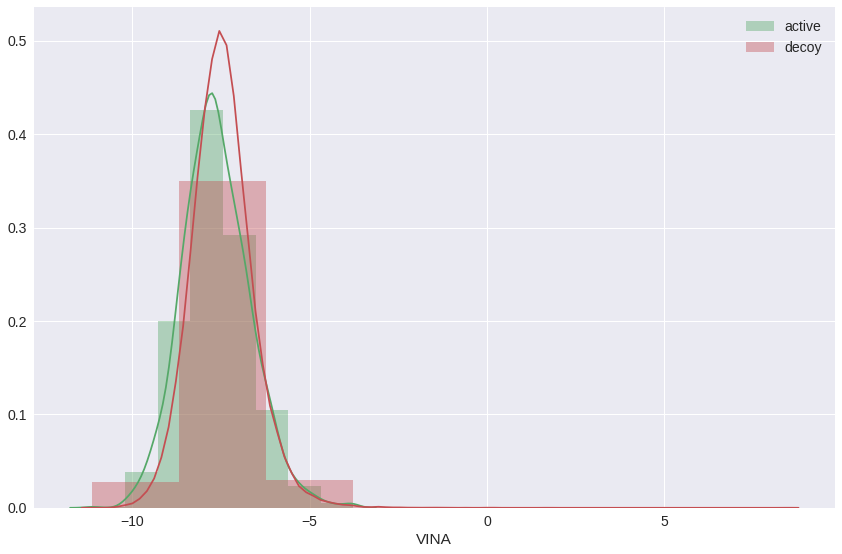

In [358]:
g = sns.FacetGrid(data=all_scores, hue='STATE', hue_order=state_list, aspect=1.5, size=8, palette=state_color_list)
g.map(sns.distplot, '', kde=True, bins=8)
_=plt.legend()
plt.savefig('{}/kde_actives_decoys.png'.format(save_folder), format='png', dpi=200,bbox_inches='tight')

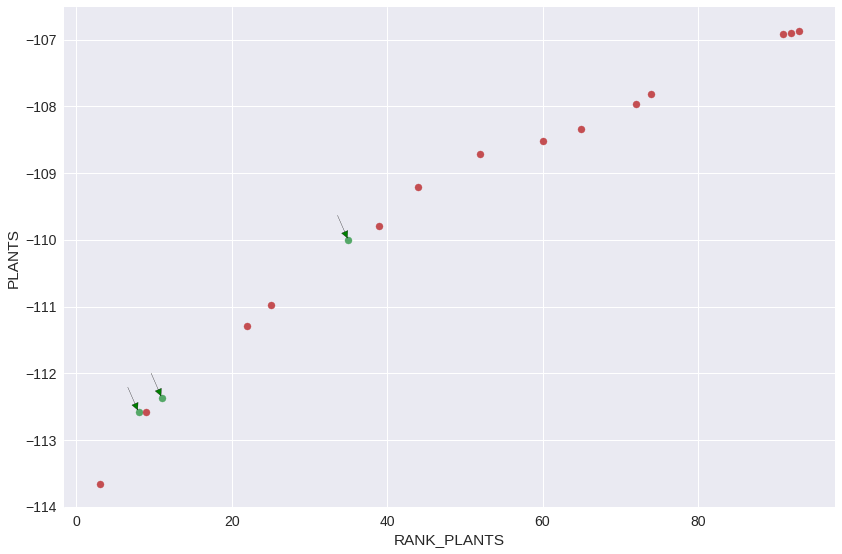

In [304]:
rank='RANK_PLANTS'
score='PLANTS'

df = all_best.loc[all_best[rank] <= 100]
g = sns.FacetGrid(data=df ,hue='STATE', hue_order=state_list, aspect=1.5, size=8, palette=state_color_list)
g.map(plt.scatter, rank,score, s=50)
for pose in df['POSE'].unique():
    temp = df.loc[df['POSE'] == pose]
    state = temp['STATE'].values[0]
    if state == 'active':
        x = temp[rank].values[0]
        y = temp[score].values[0]
        plt.annotate('', 
                     xy=[x,y], xytext=[x-1.5,y+0.4],
                     arrowprops=dict(facecolor='green',
                                    arrowstyle="-|>", connectionstyle="arc3,rad=0"))

## Enrichment Factor

In [389]:
temp = []
nb_actives_total = len(actives)
nb_compounds_total = len(all_best)
for score in ['PLANTS','VINA','MMPBSA','MMGBSA']:
    for perc in np.arange(0.5, 100.5, 0.5):
        x = int(perc*nb_compounds_total/100)
        df = all_best.sort_values(score).head(x)
        nb_actives_x = len(df.loc[df['STATE'] == 'active'])
        nb_compounds_x = len(df)
        try:
            efactor = (nb_actives_x * nb_compounds_total) / (nb_compounds_x * nb_actives_total)
        except ZeroDivisionError:
            efactor = np.NaN
        finally:
            temp.append([perc,x,efactor,score])
EF = pd.DataFrame(temp, columns=['Percentage','Nb of compounds selected', 'Enrichment Factor','SCORE'])

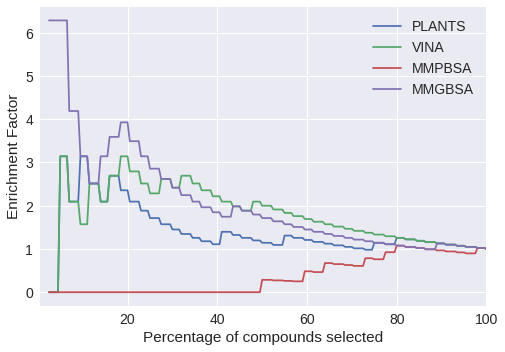

In [390]:
plt.figure()
ax=plt.gca()
for i,score in enumerate(['PLANTS','VINA','MMPBSA','MMGBSA']):
    EF.loc[EF['SCORE'] == score].plot(x='Percentage', y='Enrichment Factor', color=sns.color_palette('deep')[i], ax=ax, label=score)
plt.xlabel('Percentage of compounds selected')
_=plt.ylabel('Enrichment Factor')

## ROC curves

In [378]:
temp = []

# number of positives and negatives in dataset
p = len(all_best.loc[all_best['STATE'] == 'active'])
n = len(all_best.loc[all_best['STATE'] == 'decoy'])

for score in ['PLANTS','VINA','MMPBSA','MMGBSA']:
    for fraction in np.arange(0.01, 1.01, 0.01):
        # convert fraction to an integer for range selection
        x = int(fraction*len(all_best))
        # dataset containing fraction of positives
        pos = all_best.sort_values(score)[:x]
        # number of true positives
        tp = len(pos.loc[pos['STATE'] == 'active'])
        # number of false positives
        fp = len(pos.loc[pos['STATE'] == 'decoy'])
        # rates for ROC curves
        tpr = tp/p
        fpr = fp/n
        temp.append([fraction,tpr,fpr,score])

ROC = pd.DataFrame(temp, columns=['threshold','TPR', 'FPR','SCORE'])

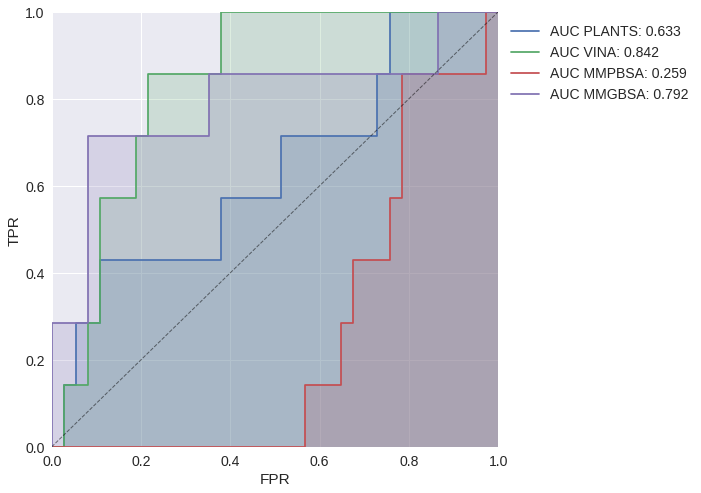

In [393]:
AUC={}
plt.figure(figsize=(8,8))
ax=plt.gca()
for i,score in enumerate(['PLANTS','VINA','MMPBSA','MMGBSA']):
    temp = ROC.loc[ROC['SCORE'] == score]
    AUC[score] = auc(temp['FPR'], temp['TPR'])
    temp.plot(x='FPR', y='TPR', ax=ax, color=sns.color_palette('deep')[i], label='AUC {}: {:.3f}'.format(score,AUC[score]))
    ax.fill_between(temp['FPR'], 0, temp['TPR'], alpha=0.2)

ax.plot((0,1),(0,1), c='k', linestyle='--', linewidth=1.0, alpha=0.5)    
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
ax = plt.gca()
ax.set_xlim([0,1])
_=ax.set_ylim([0,1])

In [388]:
all_best

,LIGAND,POSE,STATE,RANK_PLANTS,PLANTS,RANK_VINA,VINA,RANK_MMGBSA,MMGBSA,RANK_MMPBSA,MMPBSA
0,ZINC00934007_entry_00013,ZINC00934007_entry_00013_conf_01,decoy,3,-113.654,372,-9.23384,43,-44.704604,45,-12.3757
1,ZINC03833858_entry_00059,ZINC03833858_entry_00059_conf_01,active,8,-112.580,320,-9.29178,10,-52.897591,84,10.6342
2,ZINC00918434_entry_00039,ZINC00918434_entry_00039_conf_01,decoy,9,-112.575,1062,-8.65986,75,-39.430147,61,-6.7510
3,ZINC03833856_entry_00057,ZINC03833856_entry_00057_conf_01,active,11,-112.369,1,-11.11349,92,-36.602069,116,52.5117
4,ZINC01489197_entry_00081,ZINC01489197_entry_00081_conf_01,decoy,22,-111.287,13,-10.31540,42,-44.734894,40,-16.5697
5,ZINC03944688_entry_00061,ZINC03944688_entry_00061_conf_01,decoy,25,-110.970,1158,-8.59862,20,-50.322583,21,-23.6211
6,ZINC03833859_entry_00060,ZINC03833859_entry_00060_conf_01,active,35,-110.005,86,-9.82134,44,-44.687059,99,20.5001
7,ZINC01058141_entry_00053,ZINC01058141_entry_00053_conf_01,decoy,39,-109.795,293,-9.33239,47,-44.143863,0,-40.4275
8,ZINC00918635_entry_00043,ZINC00918635_entry_00043_conf_01,decoy,44,-109.213,188,-9.50233,64,-41.458279,58,-7.1568
9,ZINC00918649_entry_00046,ZINC00918649_entry_00046_conf_01,decoy,52,-108.708,580,-9.01566,60,-41.768963,118,68.0986
